# Computing daily averages from transaction data - Part 2 (using pandas and some R magic)

In [Part 1 of this post](https://misken.github.io/blog/daily_averages_cycleshare/), we discuss the importance of taking into account days with zero activity as well as carefully specifiying the date range for analysis when computing things like the average number of bike trips by day in a bike share system. Obviously, this applies more generally to computing averages number of events per day. We showed an approach to dealing with these complications.

In Part 2 of this post, we'll extend this to cases in which we might want to group by an additional field (e.g. station_id for the bike share example) and see how this problem is just one part of the general problem of doing occupancy analysis based on transaction data. We'll see how the [hillmaker](https://github.com/misken/hillmaker) package can make these types of analyses easier.

In [1]:
import pandas as pd

In [2]:
trip = pd.read_csv('trip.csv', parse_dates = ['starttime', 'stoptime'])
trip['tripdate'] = trip['starttime'].map(lambda x: x.date())

In [3]:
trip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286857 entries, 0 to 286856
Data columns (total 13 columns):
trip_id              286857 non-null int64
starttime            286857 non-null datetime64[ns]
stoptime             286857 non-null datetime64[ns]
bikeid               286857 non-null object
tripduration         286857 non-null float64
from_station_name    286857 non-null object
to_station_name      286857 non-null object
from_station_id      286857 non-null object
to_station_id        286857 non-null object
usertype             286857 non-null object
gender               181557 non-null object
birthyear            181553 non-null float64
tripdate             286857 non-null object
dtypes: datetime64[ns](2), float64(2), int64(1), object(8)
memory usage: 28.5+ MB


In [5]:
trip.head()

,trip_id,starttime,stoptime,bikeid,tripduration,from_station_name,to_station_name,from_station_id,to_station_id,usertype,gender,birthyear,tripdate
0,431,2014-10-13 10:31:00,2014-10-13 10:48:00,SEA00298,985.935,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Male,1960.0,2014-10-13
1,432,2014-10-13 10:32:00,2014-10-13 10:48:00,SEA00195,926.375,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Male,1970.0,2014-10-13
2,433,2014-10-13 10:33:00,2014-10-13 10:48:00,SEA00486,883.831,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Female,1988.0,2014-10-13
3,434,2014-10-13 10:34:00,2014-10-13 10:48:00,SEA00333,865.937,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Female,1977.0,2014-10-13
4,435,2014-10-13 10:34:00,2014-10-13 10:49:00,SEA00202,923.923,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Male,1971.0,2014-10-13


# What is the average number of bike rentals per day from each station?

Not only do we need to take into account days in which no bikes were rented from each of the stations, we have to decide how we want to handle the fact that not all stations were open for the period of time represented in the `trip` dataframe. 

In [6]:
print("The first trip was at {}.".format(trip.starttime.min()))
print("The last trip was at {}.".format(trip.starttime.max()))

The first trip was at 2014-10-13 10:31:00.
The last trip was at 2016-08-31 23:49:00.


We can get a sense of the timeframes for when individual stations were open by looking an min and max of the `starttime` field.

In [7]:
trip.groupby('from_station_id')['starttime'].aggregate(['min', 'max'])

,min,max
from_station_id,,
8D OPS 02,2016-08-12 09:03:00,2016-08-12 09:06:00
BT-01,2014-10-13 15:39:00,2016-08-31 22:13:00
BT-03,2014-10-13 12:35:00,2016-08-31 17:21:00
BT-04,2014-10-13 12:05:00,2016-08-31 19:31:00
BT-05,2014-10-13 13:08:00,2016-08-31 18:21:00
CBD-03,2014-10-13 13:30:00,2016-08-31 19:36:00
CBD-04,2015-07-27 15:52:00,2016-08-31 20:44:00
CBD-05,2014-10-13 11:52:00,2016-08-31 17:26:00
CBD-06,2014-10-13 10:31:00,2016-08-31 20:32:00


Let's look at the `station.csv` file so that we can see the installation and decommision dates.

In [8]:
station = pd.read_csv('station.csv', 
                      parse_dates = ['install_date', 'modification_date', 'decommission_date'])

In [9]:
station.head(15)

,station_id,name,lat,long,install_date,install_dockcount,modification_date,current_dockcount,decommission_date
0,BT-01,3rd Ave & Broad St,47.618418,-122.350964,2014-10-13,18,NaT,18,NaT
1,BT-03,2nd Ave & Vine St,47.615829,-122.348564,2014-10-13,16,NaT,16,NaT
2,BT-04,6th Ave & Blanchard St,47.616094,-122.341102,2014-10-13,16,NaT,16,NaT
3,BT-05,2nd Ave & Blanchard St,47.613110,-122.344208,2014-10-13,14,NaT,14,NaT
4,CBD-03,7th Ave & Union St,47.610731,-122.332447,2014-10-13,20,NaT,20,NaT
5,CBD-04,Union St & 4th Ave,47.609221,-122.335596,2015-07-27,18,NaT,18,NaT
6,CBD-05,1st Ave & Marion St,47.604058,-122.335800,2014-10-13,20,NaT,20,NaT
7,CBD-06,2nd Ave & Spring St,47.605950,-122.335768,2014-10-13,20,2015-11-09,18,NaT
8,CBD-07,City Hall / 4th Ave & James St,47.603509,-122.330409,2014-10-13,20,NaT,20,NaT
9,CBD-13,2nd Ave & Pine St,47.610185,-122.339641,2014-10-13,18,NaT,18,NaT


To simplify things, let's only consider trips for stations who have **not** been decommissioned.

In [10]:
# Create a list of stations to consider for the analysis
active_stations = list(station[station.decommission_date.isna()]['station_id'])
# Only keep records for active stations
trip = trip[trip.from_station_id.isin(active_stations)]

Now let's create a DataFrame containing the analysis start and end dates for each active stations. For the start date we'll use the `install_date` field and for end date we'll use the last date in the trip data - 2016-08-31.

In [11]:
# Just grab the rows of active stations
station_dates = station[station.decommission_date.isna()]
# Just grab columns of interest
station_dates = station_dates[['station_id','install_date','decommission_date']]
# Rename the date columns
station_dates.rename(columns={'install_date': 'start_date', 'decommission_date': 'end_date'},
                    inplace=True)
# Set end date for all stations
station_dates.end_date = pd.datetime(2016, 8, 31)
# Check out the result
station_dates.head(7)

,station_id,start_date,end_date
0,BT-01,2014-10-13,2016-08-31
1,BT-03,2014-10-13,2016-08-31
2,BT-04,2014-10-13,2016-08-31
3,BT-05,2014-10-13,2016-08-31
4,CBD-03,2014-10-13,2016-08-31
5,CBD-04,2015-07-27,2016-08-31
6,CBD-05,2014-10-13,2016-08-31


In Part 1 we outlined the basic strategy for computing the average number of daily events when some days might not have any events. 

1. Create a range of dates based on the start and end date of the time period of interest.
2. Create an empty DataFrame using the range of dates as the index. For convenience, add weekday column based on date to facility day of week analysis. Let's call this new DataFrame the "seeded" DataFrame
3. Use groupby on the original trip DataFrame to compute number of trips by date and store result as DataFrame
4. Merge the two DataFrames on their indexes (tripdate) but do a "left join". Pandas `merge` function is perfect for this.
5. If there are dates with no trips, they'll have missing data in the new merged DataFrame. Update the missing values to 0 using the `fillna` function in pandas.
6. Now you can compute overall mean number of trips per day. You could also compute means by day of week.

In order to compute the average number of trips per day by station, a few details in the above process have to be generalized.

* In Step 1, the start and end dates can depend on the station.
* In Step 2, we need a DataFrame containing each station and its associated date range.
* In Step 3, we need to group by both station and trip date.


## Accounting for zero days and station specific analysis timeframe

### Steps 1 and 2: Create an empty DataFrame using stations and associated range of dates as the MultiIndex.

We'll construct the desired MultiIndex from a list of tuples of station ids and dates. To create the list of tuples we can use a list comprehension to iterate over the rows of the `station_dates` dataframe and associated date range. Gotta love list comprehensions.

In [12]:
index_tuples = [(row.station_id, d) for index, row in station_dates.iterrows() 
                         for d in pd.date_range(row.start_date, row.end_date)]

print(index_tuples[:5])

[('BT-01', Timestamp('2014-10-13 00:00:00', freq='D')), ('BT-01', Timestamp('2014-10-14 00:00:00', freq='D')), ('BT-01', Timestamp('2014-10-15 00:00:00', freq='D')), ('BT-01', Timestamp('2014-10-16 00:00:00', freq='D')), ('BT-01', Timestamp('2014-10-17 00:00:00', freq='D'))]


Create the empty DataFrame and add a weekday column for convenience.

In [13]:
trips_by_station_date_seeded = pd.DataFrame(index=pd.MultiIndex.from_tuples(index_tuples))

In [14]:
# Add weekday column to new dataframe
trips_by_station_date_seeded['weekday'] = \
    trips_by_station_date_seeded.index.get_level_values(1).map(lambda x: x.weekday())

trips_by_station_date_seeded.index.names = ['from_station_id', 'tripdate']
print(trips_by_station_date_seeded.head())
print(trips_by_station_date_seeded.tail())

                            weekday
from_station_id tripdate           
BT-01           2014-10-13        0
                2014-10-14        1
                2014-10-15        2
                2014-10-16        3
                2014-10-17        4
                            weekday
from_station_id tripdate           
WF-03           2016-08-27        5
                2016-08-28        6
                2016-08-29        0
                2016-08-30        1
                2016-08-31        2


### Step 3: Use groupby on the original trip DataFrame to compute number of trips by station by date 

In [15]:
# Create a Group by object using from_station_id and tripdate
grp_station_date = trip.groupby(['from_station_id', 'tripdate'])

# Compute number of trips by date and check out the result
trips_by_station_date = pd.DataFrame(grp_station_date.size(), columns=['num_trips'])
print(trips_by_station_date.head())

                            num_trips
from_station_id tripdate             
BT-01           2014-10-13         20
                2014-10-14         28
                2014-10-15          8
                2014-10-16         24
                2014-10-17         16


### Step 4: Merge the two DataFrames on their indexes but do a "left join". 

Pandas `merge` function is perfect for this. The `left_index=True, right_index=True` are telling pandas to use those respective indexes
as the joining columns. Check out the [documentation](http://pandas.pydata.org/pandas-docs/stable/merging.html#database-style-dataframe-joining-merging) for `merge()`.

In [16]:
# Merge the two dataframes doing a left join (with seeded table on left)
trips_by_station_date_merged = pd.merge(trips_by_station_date_seeded, 
                                        trips_by_station_date, how='left', 
                                        left_index=True, right_index=True, sort=True)

In [19]:
trips_by_station_date_merged[100:125]

weekday  num_trips
from_station_id tripdate                      
BT-01           2015-01-21        2        2.0
                2015-01-22        3        8.0
                2015-01-23        4       12.0
                2015-01-24        5       28.0
                2015-01-25        6       20.0
                2015-01-26        0       12.0
                2015-01-27        1       12.0
                2015-01-28        2       10.0
                2015-01-29        3       14.0
                2015-01-30        4       10.0
                2015-01-31        5       14.0
                2015-02-01        6        2.0
                2015-02-02        0        2.0
                2015-02-03        1        6.0
                2015-02-04        2        8.0
                2015-02-05        3        2.0
                2015-02-06        4        NaN
                2015-02-07        5       14.0
                2015-02-08        6       14.0
                2015-02-09        0       10.0
                2015-02-10        1        8.0
                2015-02-11        2       10.0
                2015-02-12        3       18.0
                2015-02-13        4       30.0
                2015-02-14        5       52.0

### Step 5: Replace missing values with zeroes for those dates with no trips

If there are dates with no trips, they'll have missing data in the new merged DataFrame. Update the missing values to 0 using the `fillna` function in pandas. Remember, these are the instances of "zero activity" that would cause biased (high) estimates of the average number of daily trips.

In [20]:
# How many missing values do we have?
trips_by_station_date_merged['num_trips'].isna().sum()

3072

In [21]:
# Fill in any missing values with 0.
trips_by_station_date_merged['num_trips'] = trips_by_station_date_merged['num_trips'].fillna(0)
trips_by_station_date_merged[100:125]

weekday  num_trips
from_station_id tripdate                      
BT-01           2015-01-21        2        2.0
                2015-01-22        3        8.0
                2015-01-23        4       12.0
                2015-01-24        5       28.0
                2015-01-25        6       20.0
                2015-01-26        0       12.0
                2015-01-27        1       12.0
                2015-01-28        2       10.0
                2015-01-29        3       14.0
                2015-01-30        4       10.0
                2015-01-31        5       14.0
                2015-02-01        6        2.0
                2015-02-02        0        2.0
                2015-02-03        1        6.0
                2015-02-04        2        8.0
                2015-02-05        3        2.0
                2015-02-06        4        0.0
                2015-02-07        5       14.0
                2015-02-08        6       14.0
                2015-02-09        0       10.0
                2015-02-10        1        8.0
                2015-02-11        2       10.0
                2015-02-12        3       18.0
                2015-02-13        4       30.0
                2015-02-14        5       52.0

### Step 6: Compute statistics of interest

Now we can safely compute means and other statistics of interest for the `num_trips` column after grouping by `from_station_id`. Since we have taken the zero activity days into account, the stations having count values less than 689 are those stations which were installed sometime after 2014-10-13 (the installation date is in the `station` table).

In [22]:
trips_by_station_date_merged.groupby('from_station_id')['num_trips'].describe()

,count,mean,std,min,25%,50%,75%,max
from_station_id,,,,,,,,
BT-01,689.0,15.869376,10.729919,0.0,8.0,14.0,22.00,62.0
BT-03,689.0,11.854862,7.494522,0.0,6.0,10.0,16.00,52.0
BT-04,689.0,6.798258,4.590017,0.0,3.0,6.0,10.00,26.0
BT-05,689.0,9.100145,6.731142,0.0,4.0,8.0,13.00,42.0
CBD-03,689.0,8.062409,7.649699,0.0,3.0,6.0,10.00,57.0
CBD-04,402.0,6.699005,4.044817,0.0,4.0,7.0,9.00,22.0
CBD-05,689.0,8.165457,5.902446,0.0,4.0,7.0,12.00,50.0
CBD-06,689.0,7.930334,6.506778,0.0,3.0,7.0,11.00,52.0
CBD-07,689.0,5.271408,5.189189,0.0,2.0,4.0,8.00,72.0


Can even do by day of week.

In [23]:
trips_by_station_date_merged.groupby(['from_station_id', 'weekday'])['num_trips'].describe()

count       mean        std  min   25%   50%    75%  \
from_station_id weekday                                                        
BT-01           0         99.0  15.282828   9.574669  2.0  8.00  13.0  20.00   
                1         99.0  13.949495   8.374370  2.0  8.00  12.0  19.50   
                2         99.0  13.525253   7.661650  2.0  8.00  12.0  18.00   
                3         98.0  15.285714  10.632570  0.0  7.25  13.0  18.00   
                4         98.0  17.377551  11.544191  0.0  9.25  16.0  21.75   
                5         98.0  20.632653  14.058338  0.0  8.25  18.0  30.75   
                6         98.0  15.081633  10.674832  0.0  6.00  14.5  22.00   
BT-03           0         99.0  11.676768   6.948540  1.0  7.00  11.0  16.00   
                1         99.0  12.151515   6.153419  2.0  8.00  11.0  16.00   
                2         99.0  12.676768   7.296670  1.0  7.00  12.0  17.50   
                3         98.0  12.336735   7.303359  0.0  6.25  11.5  16.00   
                4         98.0  12.755102   7.065323  0.0  7.00  12.0  18.00   
                5         98.0  10.877551   8.820390  0.0  4.00   8.5  15.00   
                6         98.0  10.500000   8.474644  0.0  5.00   9.0  14.00   
BT-04           0         99.0   7.858586   5.076979  0.0  4.00   7.0  10.00   
                1         99.0   7.878788   4.291122  1.0  5.00   7.0  10.00   
                2         99.0   7.919192   4.006823  0.0  5.00   8.0  10.00   
                3         98.0   7.816327   4.782586  0.0  4.00   7.0  11.00   
                4         98.0   7.755102   4.240359  0.0  5.00   7.0  10.00   
                5         98.0   4.346939   3.964019  0.0  2.00   4.0   6.00   
                6         98.0   3.979592   3.508398  0.0  1.00   3.0   6.00   
BT-05           0         99.0   9.454545   6.429004  1.0  4.50   8.0  13.50   
                1         99.0   9.030303   6.333350  1.0  4.00   8.0  13.00   
                2         99.0   9.040404   6.626969  0.0  4.00   7.0  12.50   
                3         98.0   9.540816   7.211343  0.0  4.00   8.0  14.00   
                4         98.0  10.255102   6.709451  0.0  5.00   9.0  14.00   
                5         98.0   9.000000   7.550517  0.0  3.00   8.0  13.00   
                6         98.0   7.377551   5.999167  0.0  3.00   7.0  10.00   
CBD-03          0         99.0   8.585859   8.279567  0.0  4.00   6.0  10.00   
                1         99.0   8.393939   6.589754  0.0  4.00   6.0  12.00   
...                        ...        ...        ...  ...   ...   ...    ...   
UW-10           5         98.0   2.377551   3.131204  0.0  0.00   1.5   3.75   
                6         98.0   1.775510   3.000105  0.0  0.00   0.0   2.00   
UW-11           0         44.0   3.272727   3.142830  0.0  1.00   3.0   5.00   
                1         44.0   3.181818   3.074824  0.0  0.00   2.0   6.00   
                2         44.0   3.431818   3.030064  0.0  0.00   3.0   6.00   
                3         44.0   3.772727   3.469895  0.0  1.00   2.5   6.00   
                4         44.0   3.681818   3.489337  0.0  0.75   3.0   6.00   
                5         44.0   2.636364   3.424202  0.0  0.00   1.0   3.25   
                6         44.0   2.477273   3.480769  0.0  0.00   1.0   3.00   
WF-01           0         99.0  17.212121  11.908900  0.0  7.00  16.0  26.00   
                1         99.0  16.222222  10.312025  2.0  8.00  14.0  21.50   
                2         99.0  15.616162  10.238689  2.0  7.00  13.0  22.00   
                3         98.0  18.438776  11.849630  2.0  9.00  17.5  26.00   
                4         98.0  17.979592  13.641945  0.0  6.00  14.0  28.00   
                5         98.0  24.530612  19.283669  0.0  8.00  22.0  37.00   
                6         98.0  22.704082  19.682641  0.0  5.25  20.0  34.75   
WF-03           0          3.0   4.000000   1.000000  3.0  3.50   4.0   4.50   
                1        

## A similar example using R - airline flights

Here's how you can do the same thing using R. I'll use the `nycflights13` package and we'll compute the average number of flights by day of week by carrier.

In order to use R magic within Jupyter notebook cells, you need to:

    pip install rpy2
    
The latest version (2.9.4 as of this post) requires the `tzlocal` module as well.

    pip install tzlocal
    
Now you can load the `rpy2.ipython` module via a magic command.

In [25]:
%load_ext rpy2.ipython

Now just put `%%R` at top of any cell you want to treat as an R code chunk.

In [30]:
%%R
library(dplyr, quietly = TRUE, warn.conflicts = FALSE, verbose = FALSE)
library(lubridate, quietly = TRUE, warn.conflicts = FALSE, verbose = FALSE)
library(ggplot2, quietly = TRUE, warn.conflicts = FALSE, verbose = FALSE)
library(nycflights13, quietly = TRUE, warn.conflicts = FALSE, verbose = FALSE)

Load the NYC Flights data package and add a flight date field.

In [31]:
%%R
flights <- nycflights13::flights
flights$fl_date <- with(flights, ISOdate(year, month, day))

Count the number of flights by date by carrier.

In [32]:
%%R
flights_by_date_carrier_1 <- flights %>%
  group_by(carrier, fl_date) %>%
  summarize(numflights = n())

We need to make sure that we have a data frame containing every combination of `fl_date` and `carrier` so that the days with zero flights are properly accounted for when computing the average number of flights by day of week. R has a function called `expand.grid` which is perfect for this. I’ll create two vectors - one containing all the dates and one containing all the carriers. Then `expand.grid` will create a dataframe with all the combinations of the elements of two vectors.

In [33]:
%%R
dates <- seq(ymd('2013-01-01'),ymd('2013-12-31'),by='days')
carriers <- unique(flights$carrier)
date_carrier <- expand.grid(carriers, dates)
names(date_carrier) <- c("carrier", "fl_date")

Now we can merge the two dataframes using a left join.

In [34]:
%%R
flights_by_date_carrier <- merge(x = date_carrier, y = flights_by_date_carrier_1,
                      by.x = c("carrier", "fl_date"),
                      by.y = c("carrier", "fl_date"),
                      all.x = TRUE)

Add a day of week column for convenience.

In [35]:
%%R
flights_by_date_carrier$weekday <- wday(flights_by_date_carrier$fl_date)

Finally, compute the average number of flights.

In [36]:
%%R
flights_carrier_dow <- flights_by_date_carrier %>%
  group_by(carrier, weekday) %>%
  summarize(
    avg_numflights = mean(numflights)
  )

Let's plot it.

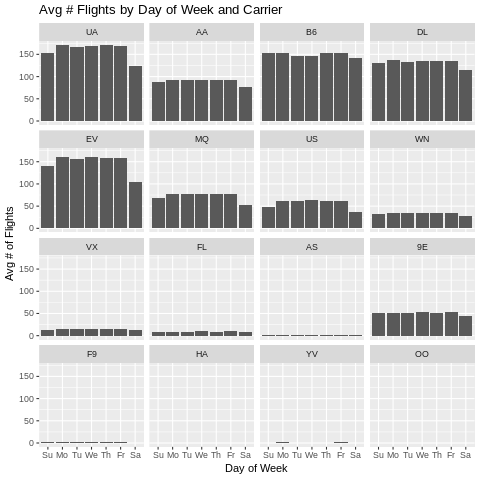

In [37]:
%%R
ggplot(data=flights_carrier_dow) + geom_bar(aes(x=factor(weekday, labels=c("Su","Mo","Tu","We","Th","Fr","Sa")), y=avg_numflights), stat = "identity") + facet_wrap(~carrier) + 
  xlab("Day of Week") +
  ylab("Avg # of Flights") +
  ggtitle("Avg # Flights by Day of Week and Carrier")

## Closing remarks - check out hillmaker

In addition to simply counting number of bike rentals (or flights), we might be interested in related statistics such as the average and percentiles of the number of bikes in use by time of day and day of week. My [hillmaker](https://github.com/misken/hillmaker) package is designed for just such analysis. You can find an example here of it being used to [analyze the Pronto Cycle Share data](https://misken.github.io/blog/basic_usage_cycleshare/).